  # Test of multiclass classifier
## (with g-r color and non-detections)

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier

  ### Definition of names for plots and files

In [2]:
date = '20190925'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v3/labels.pkl'
detections_file = '../alerce_trainingset/training_set_v3/detections.pkl'
features_file = '../alerce_trainingset/training_set_v3/features.pkl'
non_detections_file = '../alerce_trainingset/training_set_v3/training_non_det_v3.h5'

#where the RF models are saved
model_file = 'stat_multiclassRF/rf_model_multiclass_'+date

#confusion matrixes
conf_matrix_name = 'stat_multiclassRF/confusion_matrix_rf_model_multiclass_'+date

#feature importances
feature_importance_name = 'stat_multiclassRF/feature_importance_rf_model_multiclass_'+date


### reading the training set files 


In [3]:
df_nd = pd.read_hdf(non_detections_file)
df_feat = pd.read_pickle(features_file)
df_labels = pd.read_pickle(labels_file)
df_detections = pd.read_pickle(detections_file)

#deleting columns in df_nd with name ending in "_3"
for col in list(df_nd):
    if col[-2:] == "_3":
        df_nd.drop(col, inplace=True, axis=1)

#getting gscore from the detections file
df_det = df_detections.groupby(['oid'])
df_sgscore = df_det['sgscore1'].median()
df_sgscore = df_sgscore.to_frame()

#creating color features
df_nd["g_r_max"] = df_nd.min_mag_fid_1 - df_nd.min_mag_fid_2
df_feat["g_r_mean"] = df_feat.Mean_1 - df_feat.Mean_2

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RS CVn'), 'class_original'] = 'RS-CVn'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'

#defining the classes included in the RF model
label_order = ['AGN-I', 'Blazar', 'CV/Nova', 'LPV', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'RS-CVn', 'Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']

#combining all the DF
df = labels.join(df_sgscore).join(df_feat).join(df_nd.drop(rm_nd_cols, axis=1))
df.drop(['Mean_1', 'Mean_2', 'class_original'], axis=1, inplace=True)
df.fillna(-999,inplace=True)
df.head()

,sgscore1,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,...,delta_mjd_fid_2,delta_mag_fid_1,delta_mag_fid_2,dmag_non_det_fid_1,dmag_non_det_fid_2,dmag_first_det_fid_1,dmag_first_det_fid_2,positive_fraction_1,positive_fraction_2,g_r_max
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aacjwvd,0.995625,7.0,0.212099,0.991939,2.0,0.285714,0.0,1.852171,0.282442,0.154042,...,308.101134,0.776394,0.682226,1.219803,1.748352,0.443409,0.969252,0.714286,0.500000,0.595699
ZTF17aadecrr,0.995417,32.0,0.453344,1.000000,1.0,0.281250,0.0,0.014502,0.743876,97.969476,...,304.160069,3.200789,2.505141,4.599982,-999.000000,2.518738,-999.000000,0.705882,0.828571,0.440407
ZTF18adaksvf,0.999167,4.0,-999.000000,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,...,192.702361,0.441719,2.004902,0.867128,3.203909,0.867128,1.827301,0.250000,0.500000,2.022381
ZTF18abtqdih,0.962042,15.0,0.177912,0.999373,1.0,0.333333,0.0,0.233757,0.247046,0.041649,...,381.944410,1.726843,1.324814,4.091380,-999.000000,2.787048,-999.000000,0.562500,0.250000,0.202660
ZTF18abshynt,0.986042,1.0,-999.000000,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,...,127.756667,0.000000,0.678860,0.463808,2.413713,0.463808,1.246853,0.000000,0.000000,2.198404


  ### Defining functions to plot the confusion matrix and the feature importance


In [6]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [7]:
Y_training = labels['class_original']#.values

X_training = df#.columns.values.tolist()

#splitting training set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_training,
                                Y_training, test_size=0.3, stratify=Y_training)


 ## Balanced random forest

In [9]:
#Training the RF model
rf_model = RandomForestClassifier(n_estimators=500,#500
        max_features='auto',
        max_depth=None,
        n_jobs=8,
        class_weight='balanced_subsample',
        criterion='entropy',
        min_samples_split=2,
        min_samples_leaf=1)

rf_model.fit(X_train, y_train)

#testing model performance

y_true, y_pred = y_test, rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_list = list(X_training)

with open(model_file, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model,
            'features': features_list,
            }
        pickle.dump(model_dump, pickle_file)

Accuracy: 0.5502141286315059
Balanced accuracy: 0.5439342035253202


[[2494  303    4   37    4    5   20  104    0    2    2    2    7   18
    21]
 [  69  102   30   14    1    3    1    7    0    1    2    1    0    4
    15]
 [   8    9  144    6    8    4    2    3    5    0    7   10   11    4
    11]
 [ 206  163   22 5289   23  155   38  217    0    7   30    2  112  374
   224]
 [   0    0    0    0  122   56   11   19    0    0    0    0    0    0
     0]
 [   0    0    0    0    3    4    3    3    0    0    0    0    0    0
     0]
 [   1    0    0    0   13    4   27   11    0    0    0    0    0    0
     0]
 [   1    0    0    0    0    0    1    4    0    0    0    0    0    0
     0]
 [ 333   34  135    6    0    0    0   11 1611 1841  766  307  280 1248
  1168]
 [  68   21   76    8    0    1    0    5  238  723  221  105  117  228
   273]
 [   8    0    0    1    0    0    0    0    6    3  136   27    2    9
    13]
 [  94   36   27    5    1    1    0   40   82   58  450 3339  133   86
   398]
 [   2    3    1    1    0    0    0    

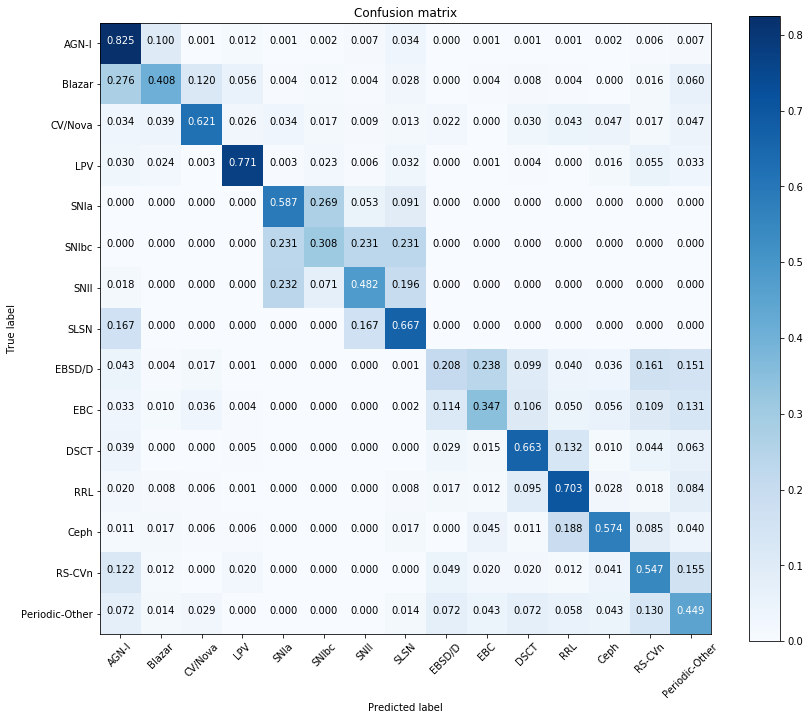

In [10]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order,conf_matrix_name)

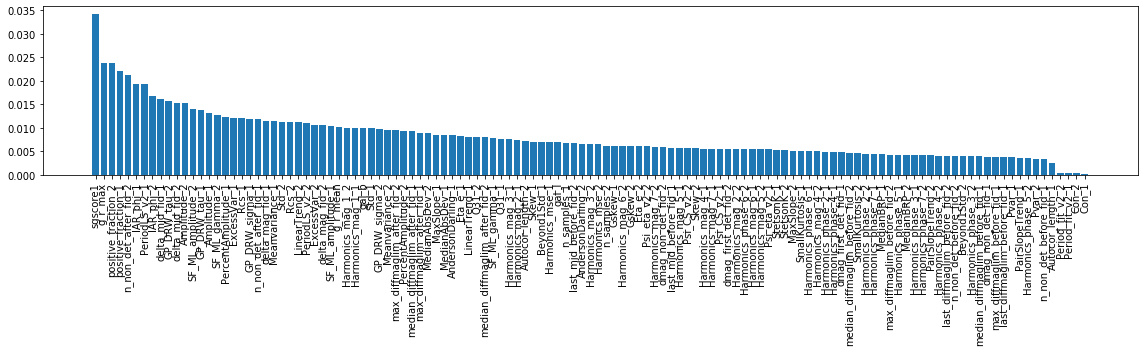

In [11]:
#plotting feature importance
plot_feature_importances(rf_model, features_list, feature_importance_name)